# Building up the Problem - A Quantitative Analysis

Upon illustrating our method in 1 example, we would like to show the full distributions of the solution. We aim to show 3 plots here:
- (a) Histograms showing the distribution of mission times for our method GATR (top row) and four benchmarks for the test set of 300 scenarios
for the three-agent-four-task CMRP. The circled letters represent the five different solutions for the single example scenario shown in the bottom row of
the figure plotted in `GATR_vs_other_benchmarks_on_one_example_(Fig3).ipynb`. 
- (b) A cumulative frequency histogram showing the percentage of GATR solutions (y-axis) with normalized mission times less than a given value
(x-axis). The solid lines represent comparison against the Opt-P benchmark (mtˆ Opt−P) for the five progressively complex problem types illustrated in Fig.
3, building up from mTSP (pink) to CMRP, our full problem (dark blue). The dashed dark blue line represents comparison against NOpt-LKH3 benchmark
(mtˆ NOpt−LKH3) for CMRP.
- (c) A graph illustrating the proportion of solutions with mtˆ below the 1% threshold for different problem types and numbers of
sub-tasks. The triangles represent the four-task problems and match the colours for the same set of experiments shown in (b).

This notebook assumes that the following sets of experiments have already been collected (indicated by `Collected: {path}` below) using the scripts in `../run`. For instructions on how to run these scripts, please refer to `../example`. This notebook focuses solely on visualizing the results.

In [8]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ast import literal_eval
import copy
import itertools
from scipy import interpolate
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from graph_attention_replanner.config import LogFileConfig

plt.rcParams["font.family"] = "sans-serif"
# https://www.fabiocrameri.ch/colourpalettes/
problem_colour_hex = [
    '#E7BBE3',  # Lighter, more distinct pink
    '#FF8C38',  # Brighter orange
    '#9FC537',  # Brighter, yellower green
    '#2F9DB2',  # Turquoise instead of forest green
    '#3B4992'   # Brighter navy blue
]
palette = sns.color_palette(problem_colour_hex)
single_color_palette = sns.color_palette([problem_colour_hex[4]])
os.system("mkdir -p ../../cache/plots")

0

In [5]:
method_presentable = {
    "gat": "GATR",
    "lkh": "NOpt-LKH3",
    "enum": "Opt-P",
    "median": "Med-P",
    "random": "Med-S",
}

problem_presentable = {
    1: "mTSP",
    2: "mTSP + Task Time",
    3: "mTSP + Start Loc.",
    4: "mTSP + Start Loc. + Task Time",
    5: "mTSP + Start Loc. + Task Time \n+ Collab",
}

method_details = {
    "gat": "gat_gpu_batch_exp100",
    "lkh": "lkh_gpu",
    "random": "random",
    "median": "median",
    "enum": "enum",
}

base_arg = {
    "mtsp_problem_type": 5,
    "num_agent": 3,
    "batch_size": 100,
}

dataset_4task_arg = {
    "num_task": 4,
    "num_node": 8,
    "discretize_level": 2,
}

dataset_3task_arg = {
    "num_task": 3,
    "num_node": 6,
    "discretize_level": 2,
}

dataset_2task_arg = {
    "num_task": 2,
    "num_node": 4,
    "discretize_level": 2,
}

dataset_6task_arg = {
    "num_task": 6,
    "num_node": 6,
    "discretize_level": 1,
}

dataset_8task_arg = {
    "num_task": 8,
    "num_node": 8,
    "discretize_level": 1,
}

dataset_env6_arg = {
    "num_task": 8,
    "num_node": 8,
    "discretize_level": 1,
}

dataset_env7_arg = {
    "num_task": 8,
    "num_node": 8,
    "discretize_level": 1,
}

datasets_arg = {
    "dataset_4task": dataset_4task_arg,
    "dataset_3task": dataset_3task_arg,
    "dataset_2task": dataset_2task_arg,
    "dataset_6task": dataset_6task_arg,
    "dataset_8task": dataset_8task_arg,
}

method_mtsp_problem_type = {
    "dataset_4task": [1, 2, 3, 4, 5],
    "dataset_3task": [5],
    "dataset_2task": [5],
    "dataset_6task": [1, 2, 3, 4],
    "dataset_8task": [1, 2, 3, 4],
}

data_seeds = [10,11,12]
# Which model to evaulate on which data, here model 0 evaulate on data 10
method_seeds = {
    10: 0,
    11: 1,
    12: 2,
}

In [6]:
def remove_stem(path):
    parts = Path(path).parts
    idx = parts.index("cache")
    relative_path = Path(*parts[idx:]) 
    return relative_path

df_list = []
for data_seed in data_seeds:
    for dataset, dataset_arg in datasets_arg.items():
        for mtsp_problem_type in method_mtsp_problem_type[dataset]:
            for method in ["gat", "lkh", "enum", "median", "random"]:
                cfg = LogFileConfig(
                    mtsp_problem_type,
                    dataset_arg["num_node"],
                    dataset_arg["num_task"],
                    dataset_arg["num_task"],
                    dataset_arg["discretize_level"],
                    dataset_arg["discretize_level"],
                    base_arg["num_agent"],
                    base_arg["num_agent"],
                    base_arg["batch_size"],
                    read_only=True,
                )
                num_exp = 1 if (method == "gat" or method == "random") else 100
                method_seed = method_seeds[data_seed] if (method == "gat") else None
                path = cfg.get_result_logfilename(
                    method=method_details[method],
                    format="csv",
                    num_exp=num_exp,
                    seed = data_seed,
                    method_seed = method_seed,
                )
                if os.path.exists(path):
                    df = pd.read_csv(path)
                    if method == "enum":
                        df.drop(columns=["all_mission_time"], inplace=True)
                    df["method"] = method
                    df["dataset"] = dataset
                    # Special case for dataset_4taskß
                    problem_num_node = dataset_arg["num_task"] if dataset == "dataset_4task" and mtsp_problem_type < 5 else dataset_arg["num_node"]
                    df["num_node"] = problem_num_node
                    df["discretize_level"] = dataset_arg["discretize_level"]
                    df["seed"] = data_seed
                    df["method_seed"] = method_seed
                    df_list.append(df)
                    print(f"Collected: {remove_stem(path)}")

                else:
                    print(f"WARNING: File not found: {remove_stem(path)}")

MERGED_DF = pd.concat(df_list, ignore_index=True)

Collected: cache/results/gat_gpu_batch_exp100/problem1_node8_task4to4_dislevel2to2_agent3to3_bs100_exp1_dataseed10_methodseed0.csv
Collected: cache/results/lkh_gpu/problem1_node8_task4to4_dislevel2to2_agent3to3_bs100_exp100_dataseed10.csv
Collected: cache/results/enum/problem1_node8_task4to4_dislevel2to2_agent3to3_bs100_exp100_dataseed10.csv
Collected: cache/results/median/problem1_node8_task4to4_dislevel2to2_agent3to3_bs100_exp100_dataseed10.csv
Collected: cache/results/random/problem1_node8_task4to4_dislevel2to2_agent3to3_bs100_exp1_dataseed10.csv
Collected: cache/results/gat_gpu_batch_exp100/problem2_node8_task4to4_dislevel2to2_agent3to3_bs100_exp1_dataseed10_methodseed0.csv
Collected: cache/results/lkh_gpu/problem2_node8_task4to4_dislevel2to2_agent3to3_bs100_exp100_dataseed10.csv
Collected: cache/results/enum/problem2_node8_task4to4_dislevel2to2_agent3to3_bs100_exp100_dataseed10.csv
Collected: cache/results/median/problem2_node8_task4to4_dislevel2to2_agent3to3_bs100_exp100_dataseed

/var/folders/bl/91ns7my95h53vfz2h_xq62yh0000gs/T/ipykernel_96745/1727223669.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/bl/91ns7my95h53vfz2h_xq62yh0000gs/T/ipykernel_96745/1727223669.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/bl/91ns7my95h53vfz2h_xq62yh0000gs/T/ipykernel_96745/1727223669.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/bl/91ns7my95h53vfz2h_xq62yh0000gs/T/ipykernel_96745/1727223669.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose labe

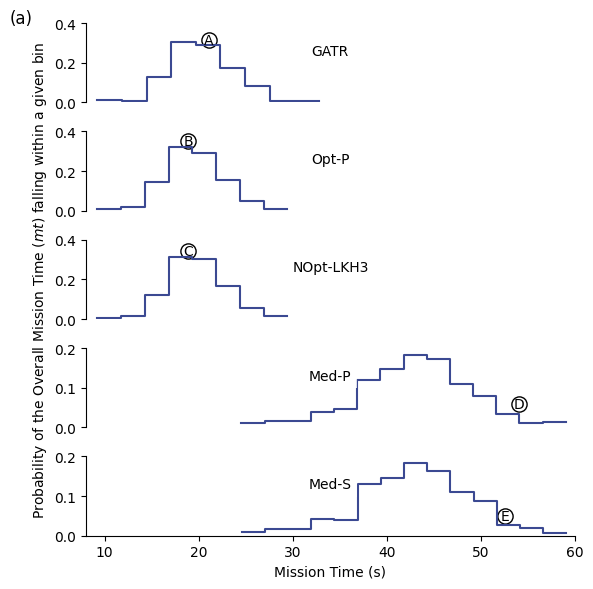

In [9]:
def transform_df(df_local, method = "gat"):
    df_local = copy.deepcopy(df_local[(df_local["dataset"]=="dataset_4task") & (df_local["mtsp_problem_type"]==5)])
    df_local = df_local[df_local["method"] == method]
    df_local = df_local.rename(columns={"mission_time": "Mission Time (s)", "method": "Method"})
    df_local = df_local.replace({"Method": method_presentable})
    return df_local

def add_circle(ax_local, problem_idx, x, y):
    c = ["A", "B", "C", "D", "E"]
    ax_local.scatter(x, y, s=120, facecolors='w', alpha=1, edgecolors='black')
    ax_local.text(x,y, c[problem_idx], color='black', alpha=1, fontsize=10, ha='center', va='center')  # ha/va = horizontal/vertical alignment


fig, axes = plt.subplots(5, 1, figsize=(6, 6))
binwidth = 2.5
from_prev_plot = [21.05, 18.89, 18.89, 54.04, 52.59]
from_prev_plot_y = [0.2867, 0.3233, 0.3133, 0.030, 0.020] # Density

for idx, method in enumerate(["gat", "enum", "lkh", "median", "random"]):
    df = transform_df(MERGED_DF, method=method)
    ax = axes[idx]
    sns.histplot(
        data=df,
        x="Mission Time (s)", 
        hue="Method",
        ax=ax,
        binwidth=binwidth,
        element="step", # comment this to find ax.patch
        fill=False,
        stat="probability",
        palette=single_color_palette,
    )

    # Title
    ax.text(
        0.5, 0.6,  # X and Y positions (relative to the plot area)
        f"{method_presentable[method]}",  # Title text
        fontsize=10,  # Font size
        color="black",  # Text colour
        ha="center",  # Align text horizontally
        transform=ax.transAxes,  # Use axis-relative coordinates
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')  # Optional: add a background box
    )

    ax.set_xlim((8, 60))
    if method == "random" or method == "median":
        ax.set_ylim((0, 0.2))
    else:
        ax.set_ylim((0, 0.4))
    ax.legend().remove()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if idx == 2:
        ax.set_ylabel(r'Probability of the Overall Mission Time ($mt$) falling within a given bin')
    else:
        ax.set_ylabel("")
    if idx < 4:
        ax.set_xlabel("")
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)
    else:
        ax.set_xlabel("Mission Time (s)")
        ax.spines['bottom'].set_visible(True)
    
    if idx == 0:
        ax.text(x=-0.05,y=0.40,s="(a)",fontsize = 12)

    add_circle(ax, idx, from_prev_plot[idx], from_prev_plot_y[idx]+0.03)

plt.tight_layout()
plt.savefig('../../cache/plots/result_a.png', bbox_inches="tight")


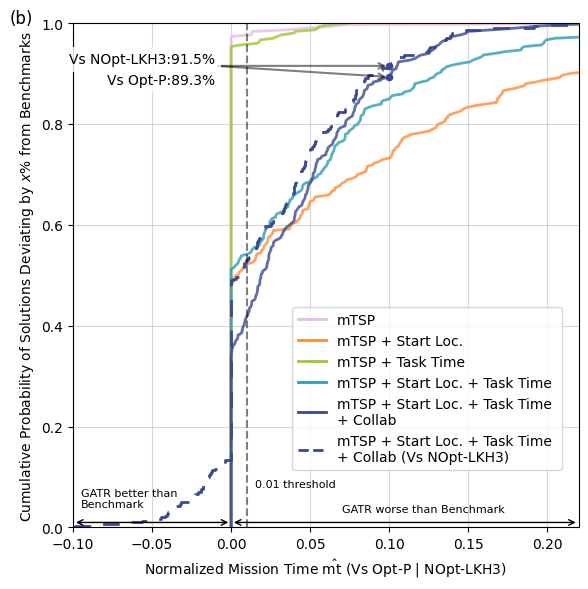

In [12]:
def find_overlapping_segments(x1, y1, x2, y2, threshold=0.01):
    """Find segments where two lines overlap"""
    overlapping_mask = (abs(y1 - y2) < threshold)
    
    # Find start and end points of overlapping segments
    segments = []
    overlap_start = None
    
    for i in range(len(overlapping_mask)):
        if overlapping_mask[i] and overlap_start is None:
            overlap_start = i
        elif not overlapping_mask[i] and overlap_start is not None:
            segments.append((overlap_start, i))
            overlap_start = None
            
    # Don't forget the last segment if it ends while overlapping
    if overlap_start is not None:
        segments.append((overlap_start, len(overlapping_mask)))
        
    return segments

def find_y_at_x(x_data, y_data, x_target=0.1):
    # Create interpolation function
    f = interpolate.interp1d(x_data, y_data, bounds_error=False)
    
    # Get y value at x=0.1
    y_at_x = f(x_target)
    return y_at_x

def transform_df(df_local, problem=3, num_node=8):
    df_local = df_local.copy()
    df_local = df_local[(df_local["num_node"]==num_node) & (df_local["mtsp_problem_type"]==problem)]

    gat = df_local[(df_local["method"]=="gat") ]
    gat = gat.sort_values(["dataset", "mtsp_problem_type", "num_node", "exp_idx"])

    lkh = df_local[(df_local["method"]=="lkh") ]
    lkh = lkh.sort_values(["dataset", "mtsp_problem_type", "num_node", "exp_idx"])

    enum = df_local[(df_local["method"]=="enum") ]
    enum = enum.sort_values(["dataset", "mtsp_problem_type", "num_node", "exp_idx"])

    median = df_local[(df_local["method"]=="median") ]
    median = median.sort_values(["dataset", "mtsp_problem_type", "num_node", "exp_idx"])

    gat[f"Delta Mission Time ({method_presentable['lkh']}-{method_presentable['enum']})/({method_presentable['median']}-{method_presentable['enum']})"] = (lkh["mission_time"].values - enum["mission_time"].values)/(median["mission_time"].values - enum["mission_time"].values)
    gat[f"Delta Mission Time ({method_presentable['gat']}-{method_presentable['enum']})/({method_presentable['median']}-{method_presentable['enum']})"] = (gat["mission_time"].values - enum["mission_time"].values)/(median["mission_time"].values - enum["mission_time"].values)
    gat[f"Delta Mission Time ({method_presentable['gat']}-{method_presentable['lkh']})/({method_presentable['median']}-{method_presentable['lkh']})"] = (gat["mission_time"].values - lkh["mission_time"].values)/(median["mission_time"].values - lkh["mission_time"].values)
    gat["Problem"] = problem_presentable[problem]
    return gat

df_list = []
for problem in [1, 2, 3, 4]:
    df = transform_df(MERGED_DF, problem=problem, num_node=4)
    df_list.append(df)
for problem in [5]:
    df = transform_df(MERGED_DF, problem=problem, num_node=8)
    df_list.append(df)

df = pd.concat(df_list, ignore_index=True)
fig, ax = plt.subplots(figsize=(6, 6))

x_col = f"Delta Mission Time ({method_presentable['gat']}-{method_presentable['enum']})/({method_presentable['median']}-{method_presentable['enum']})"
dashes_style =[[6,1], [6, 2], [6, 3], [6, 4], [6, 5]]
for count_idx, idx in enumerate([1, 3, 2, 4, 5]):
    subset = df[df["Problem"] == problem_presentable[idx]][x_col]
    x = np.sort(subset)  # Sort the data
    y = np.linspace(0, 1, len(x))  # Generate percent values (ECDF)
    alpha = 0.8
    ax.plot(x, y, label=problem_presentable[idx], linewidth=2, color=palette[count_idx], alpha=alpha, linestyle='-')
    if idx == 5:
        y_value_enum = find_y_at_x(x, y, 0.1)

# Add the new ECDF line
df = transform_df(MERGED_DF, problem=5, num_node=8)
plot2 = sns.ecdfplot(
    data=df,
    x=f"Delta Mission Time ({method_presentable['gat']}-{method_presentable['lkh']})/({method_presentable['median']}-{method_presentable['lkh']})",
    stat="proportion",
    hue="Problem",
    ax=ax,
    palette=single_color_palette,  # You can use a different palette or color here if needed
    linewidth=2,
    linestyle="--",
    dashes=[6, 5],
)
x_col = f"Delta Mission Time ({method_presentable['gat']}-{method_presentable['lkh']})/({method_presentable['median']}-{method_presentable['lkh']})"
subset = df[x_col]
x = np.sort(subset)  # Sort the data
y = np.linspace(0, 1, len(x))  # Generate percent values (ECDF)
y_value_lkh = find_y_at_x(x, y, 0.1)

ax.scatter(0.1, y_value_enum, color=palette[4], s=20, zorder=5)
ax.scatter(0.1, y_value_lkh, color=palette[4], s=20, zorder=5)
y_value_enum  = y_value_enum.round(3)
y_value_lkh  = y_value_lkh.round(3)
ax.text(x=-0.01, y=0.88, s=f"Vs {method_presentable['enum']}:{y_value_enum*100}%", color = 'black', ha="right", bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
ax.annotate("", xy=(-0.01, y_value_lkh), xytext=(0.1, y_value_enum), arrowprops=dict(arrowstyle="<-",color='black',linewidth=1.5, alpha=0.5))
ax.annotate("", xy=(-0.01, y_value_lkh), xytext=(0.1, y_value_lkh), arrowprops=dict(arrowstyle="<-",color='black',linewidth=1.5, alpha=0.5))
ax.text(x=-0.01, y=0.92, s=f"Vs {method_presentable['lkh']}:{y_value_lkh*100}%", color = 'black', ha="right", bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))


handles2, labels2 = ax.get_legend_handles_labels()  # Handles and labels from the second plot
legend_elements = [Line2D([0], [0], color=problem_colour_hex[0], lw=2,linestyle="-", label=problem_presentable[1]),
                   Line2D([0], [0], color=problem_colour_hex[1], lw=2,linestyle="-", label=problem_presentable[3]),
                   Line2D([0], [0], color=problem_colour_hex[2], lw=2,linestyle="-", label=problem_presentable[2]),
                   Line2D([0], [0], color=problem_colour_hex[3], lw=2,linestyle="-", label=problem_presentable[4]),
                   Line2D([0], [0], color=problem_colour_hex[4], lw=2,linestyle="-", label=problem_presentable[5]),
                   Line2D([0], [0], color=problem_colour_hex[4], lw=2, linestyle="--", label=problem_presentable[5]+ f" (Vs {method_presentable['lkh']})"),]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.42, 0.45))

ax.annotate('', xy=(-0.1,0.01), xytext=(0,0.01), arrowprops=dict(arrowstyle='<->'))
ax.text(x=-0.095,y=0.04,s="GATR better than \nBenchmark",fontsize = 8)
ax.annotate('', xy=(0.22,0.01), xytext=(0,0.01), arrowprops=dict(arrowstyle='<->'))
ax.text(x=0.07,y=0.03,s="GATR worse than Benchmark",fontsize = 8)

ax.vlines(x=0.01, ymin=0, ymax=1, color='black', linestyle='--', alpha=0.5)
ax.text(x=0.015,y=0.08,s="0.01 threshold",fontsize = 8)

mt = r'Normalized Mission Time $\mathregular{\hat{mt}}$'
ax.set_xlabel(f"{mt} (Vs {method_presentable['enum']} | {method_presentable['lkh']})")

ax.set_xlim(-0.1, 0.22)
ax.set_ylabel(r'Cumulative Probability of Solutions Deviating by $x\%$ from Benchmarks')
ax.tick_params(axis='both', which='minor', length=0)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.text(x=-0.14,y=1,s="(b)",fontsize = 12)
plt.tight_layout()
plt.savefig('../../cache/plots/result_b.png', bbox_inches="tight")

In [13]:
def transform_df(df_local, problem=3, num_node=8):
    df_local = df_local.copy()
    df_local = df_local[(df_local["num_node"]==num_node) & (df_local["mtsp_problem_type"]==problem)]

    gat = df_local[(df_local["method"]=="gat") ]
    gat = gat.sort_values(["dataset", "mtsp_problem_type", "num_node", "exp_idx"])

    lkh = df_local[(df_local["method"]=="lkh") ]
    lkh = lkh.sort_values(["dataset", "mtsp_problem_type", "num_node", "exp_idx"])

    enum = df_local[(df_local["method"]=="enum") ]
    enum = enum.sort_values(["dataset", "mtsp_problem_type", "num_node", "exp_idx"])

    median = df_local[(df_local["method"]=="median") ]
    median = median.sort_values(["dataset", "mtsp_problem_type", "num_node", "exp_idx"])

    gat[f"Delta Mission Time ({method_presentable['lkh']}-{method_presentable['enum']})/({method_presentable['median']}-{method_presentable['enum']})"] = (lkh["mission_time"].values - enum["mission_time"].values)/(median["mission_time"].values - enum["mission_time"].values)
    gat[f"Delta Mission Time ({method_presentable['gat']}-{method_presentable['enum']})/({method_presentable['median']}-{method_presentable['enum']})"] = (gat["mission_time"].values - enum["mission_time"].values)/(median["mission_time"].values - enum["mission_time"].values)
    gat[f"Delta Mission Time ({method_presentable['gat']}-{method_presentable['lkh']})/({method_presentable['median']}-{method_presentable['enum']})"] = (gat["mission_time"].values - lkh["mission_time"].values)/(median["mission_time"].values - enum["mission_time"].values)
    return gat


def plot_hist(df_hist, interested_x, xlim = None, file_name="diff.png", num_node=8):
    fig, axes = plt.subplots(5, figsize=(6, 6))

    if xlim is not None:
        for ax in axes:
            ax.set_xlim(xlim)
            ax.set_ylim(0,100)

    binwidth = 0.01
    for idx, problem in enumerate([1,2,3,4,5]):
        sns.histplot(
            data=transform_df(df_hist, problem=problem, num_node=num_node), 
            x=interested_x, 
            ax=axes[idx],
            binwidth=binwidth,
            color=problem_colour_hex[problem-1],
            cumulative=True,
            # edgecolor=None,
        )
        if idx == 4:
            axes[idx].get_xaxis().set_visible(True)
            axes[idx].xaxis.set_major_locator(ticker.MultipleLocator(base=0.05)) 
        else:
            axes[idx].get_xaxis().set_visible(False)

        if idx == 2:
            axes[idx].set_ylabel("Frequency")
        else:
            axes[idx].set_ylabel("")


    for i, ax in enumerate(axes):
        ax.set_xlabel(interested_x)
        ax.set_title(f"{problem_presentable[i+1]}", y=1.0, pad=-14, fontsize = 9)
        # ax.legend([f"{problem_presentable[i+1]}"], frameon=False)
        if ax.containers:
            ax.bar_label(ax.containers[0], fontsize= 9)

    plt.tight_layout()
    plt.savefig(f'../../cache/plots/{file_name}')


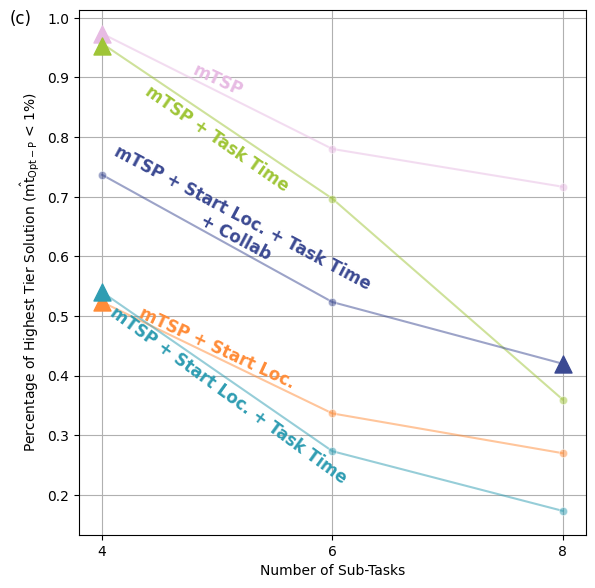

In [14]:
THRES = 0.01
def plot_hist_table(df_hist, interested_x, problem=2, num_node=8):
    df = transform_df(df_hist, problem=problem, num_node=num_node)
    all = df[interested_x].shape[0]
    count = df[df[interested_x] < THRES].shape[0]
    result = count/all
    return result

df = pd.DataFrame()
result_dict = {
    "Problem": [],
    "Node": [],
    "Count": [],
    "Type": [],
}

for interested_x in [f"Delta Mission Time ({method_presentable['gat']}-{method_presentable['enum']})/({method_presentable['median']}-{method_presentable['enum']})"]:
    for problem in [1,3,2,4,5]:
        for node in [4, 6, 8]:
            count = plot_hist_table(MERGED_DF, interested_x=interested_x, problem=problem, num_node=node)
            result_dict["Problem"].append(problem_presentable[problem])
            result_dict["Node"].append(node)
            result_dict["Count"].append(count)
            result_dict["Type"].append(interested_x)
df = pd.DataFrame(result_dict)

fig, ax = plt.subplots(figsize=(6, 6))
sns.lineplot(
    data=df, 
    x="Node", 
    y="Count", 
    hue="Problem",
    ax=ax, 
    palette=palette,
    marker = 'o',
    alpha=0.5,
)

size = 150
ax.scatter(4, 0.9733, color=palette[0], marker='^', s=size, zorder=20, alpha=1)
ax.scatter(4, 0.5233, color=palette[1], marker='^', s=size, zorder=20, alpha=1)
ax.scatter(4, 0.9533, color=palette[2], marker='^', s=size, zorder=20, alpha=1)
ax.scatter(4, 0.54, color=palette[3], marker='^', s=size, zorder=20, alpha=1)
ax.scatter(8, 0.42, color=palette[4], marker='^', s=size, zorder=20, alpha=1)

ax.legend().remove()
ax.text(x=5, y=0.87, s=f"{problem_presentable[1]}", color=palette[0], fontsize=12, ha="center", weight='bold', rotation=-25)
ax.text(x=5, y=0.38, s=f"{problem_presentable[3]}", color=palette[1], fontsize=12, ha="center", weight='bold', rotation=-25)
ax.text(x=5, y=0.71, s=f"{problem_presentable[2]}", color=palette[2], fontsize=12, ha="center", weight='bold', rotation=-35)
ax.text(x=5.1, y=0.22, s=f"{problem_presentable[4]}", color=palette[3], fontsize=12, ha="center", weight='bold', rotation=-36)
ax.text(x=5.2, y=0.51, s=f"{problem_presentable[5]}", color=palette[4], fontsize=12, ha="center", weight='bold', rotation=-28)


ax.set_xticks([4, 6, 8])
ax.grid(True)
ax.set_xlabel("Number of Sub-Tasks")
mt = r'$\mathregular{\hat{mt}_{Opt-P}}$'
ax.set_ylabel(f"Percentage of Highest Tier Solution ({mt} < 1%)")

plt.text(x=3.2,y=0.99,s="(c)",fontsize = 12)
plt.tight_layout()
plt.savefig('../../cache/plots/result_c.png', bbox_inches="tight")

# Runtime
Additional plots on runtime

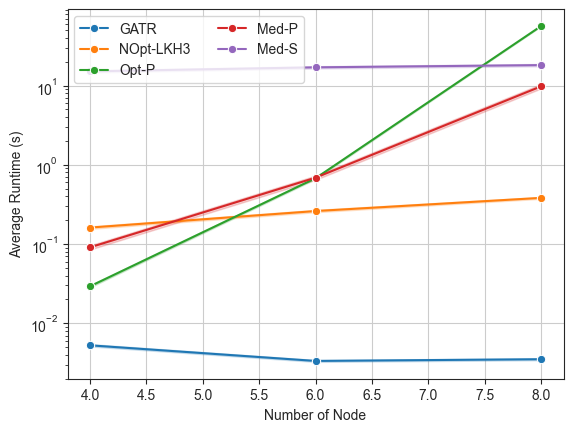

In [15]:
def transform_df(df):
    df = df.copy()
    df["method"] = df["method"].map(method_presentable)
    df["dataset"] = df["dataset"].map(problem_presentable)
    return df

sns.set_style("ticks",{'axes.grid' : True})
ax = sns.lineplot(
    data=transform_df(MERGED_DF), 
    x="num_node", 
    y="runtime", 
    hue="method",
    marker="o",
)
ax.set(yscale='log')
ax.set_xlabel("Number of Node")
ax.set_ylabel("Average Runtime (s)")
ax.legend(loc='upper left', ncol=2)

plt.savefig('../../cache/plots/runtime_main.png', bbox_inches="tight")
